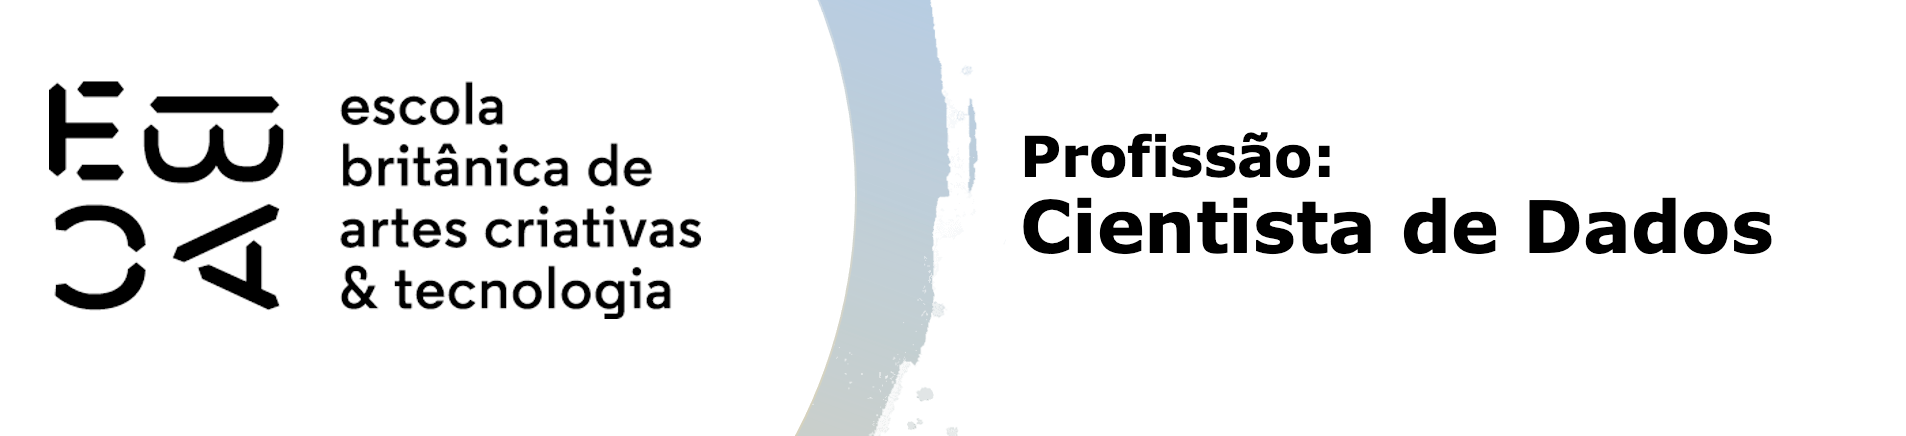

# Tarefa II

Neste projeto, estamos construindo um credit scoring para cartão de crédito, em um desenho amostral com 15 safras, e utilizando 12 meses de performance.

Carregue a base de dados ```credit_scoring.ftr```.

In [1]:
from pycaret.classification import *
import pandas as pd
from datetime import timedelta
import numpy as np
from scipy.stats import t
from sklearn import metrics
from scipy.stats import ks_2samp
from sklearn.metrics import accuracy_score
from sklearn.decomposition import PCA

import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
import statsmodels.api as sm

from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

from sklearn.preprocessing import FunctionTransformer

In [3]:
df = pd.read_feather('credit_scoring.ftr')
df.head()


,data_ref,index,sexo,posse_de_veiculo,posse_de_imovel,qtd_filhos,tipo_renda,educacao,estado_civil,tipo_residencia,idade,tempo_emprego,qt_pessoas_residencia,renda,mau
0,2015-01-01,5733,F,N,N,0,Empresário,Médio,Solteiro,Casa,43,6.873973,1.0,2515.39,False
1,2015-01-01,727,F,S,S,0,Assalariado,Médio,Casado,Casa,35,4.526027,2.0,3180.19,False
2,2015-01-01,6374,F,N,N,2,Assalariado,Médio,Casado,Casa,31,0.243836,4.0,1582.29,False
3,2015-01-01,9566,F,N,N,0,Assalariado,Médio,Casado,Casa,54,12.772603,2.0,13721.17,False
4,2015-01-01,9502,F,S,N,0,Assalariado,Superior incompleto,Solteiro,Casa,31,8.432877,1.0,2891.08,False


## Amostragem

Separe os três últimos meses como safras de validação *out of time* (oot).

Variáveis:<br>
Considere que a variável ```data_ref``` não é uma variável explicativa, é somente uma variável indicadora da safra, e não deve ser utilizada na modelagem. A variávei ```index``` é um identificador do cliente, e também não deve ser utilizada como covariável (variável explicativa). As restantes podem ser utilizadas para prever a inadimplência, incluindo a renda.


In [4]:
# Calcule a data mínima no DataFrame
data_minima = df['data_ref'].min()

# Calcule a data máxima no DataFrame
data_maxima = df['data_ref'].max()

# Calcule a data há três meses atrás a partir da data máxima
data_tres_meses_atras = data_maxima - timedelta(days=90)

# Filtre o DataFrame com base nas datas para obter 3 últimos meses
df_valid = df[(df['data_ref'] >= data_tres_meses_atras) & (df['data_ref'] <= data_maxima)]

# Filtre o DataFrame com base nas datas para obter o restante dos dados
df_ = df[df['data_ref'] < data_tres_meses_atras]

## Descritiva básica univariada

- Descreva a base quanto ao número de linhas, número de linhas para cada mês em ```data_ref```.
- Faça uma descritiva básica univariada de cada variável. Considere as naturezas diferentes: qualitativas e quantitativas.

In [5]:
df_['mes'] = df['data_ref'].dt.month

In [6]:
df_.groupby('mes').size().reset_index(name='contagem')

,mes,contagem
0,1,50000
1,2,50000
2,3,50000
3,4,50000
4,5,50000
5,6,50000
6,7,50000
7,8,50000
8,9,50000
9,10,50000


In [7]:
df_.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 600000 entries, 0 to 599999
Data columns (total 16 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   data_ref               600000 non-null  datetime64[ns]
 1   index                  600000 non-null  int64         
 2   sexo                   600000 non-null  object        
 3   posse_de_veiculo       600000 non-null  object        
 4   posse_de_imovel        600000 non-null  object        
 5   qtd_filhos             600000 non-null  int64         
 6   tipo_renda             600000 non-null  object        
 7   educacao               600000 non-null  object        
 8   estado_civil           600000 non-null  object        
 9   tipo_residencia        600000 non-null  object        
 10  idade                  600000 non-null  int64         
 11  tempo_emprego          499125 non-null  float64       
 12  qt_pessoas_residencia  600000 non-null  floa

In [8]:
df_['mau'] = df_['mau'].astype('int64')
df_valid['mau'] = df_valid['mau'].astype('int64')

In [9]:
#criando tabela metadados
metadados = pd.DataFrame(df_.dtypes, columns=['dtype'])
metadados['valores_unicos'] = df.nunique()

metadados

,dtype,valores_unicos
data_ref,datetime64[ns],15.0
index,int64,16650.0
sexo,object,2.0
posse_de_veiculo,object,2.0
posse_de_imovel,object,2.0
qtd_filhos,int64,8.0
tipo_renda,object,5.0
educacao,object,5.0
estado_civil,object,5.0
tipo_residencia,object,6.0


## Descritiva bivariada

Faça uma análise descritiva bivariada de cada variável

In [10]:
df_.corr()

,index,qtd_filhos,idade,tempo_emprego,qt_pessoas_residencia,renda,mau,mes
index,1.000000,0.031736,-0.048188,-0.034609,0.033585,-0.012409,0.008819,-0.000674
qtd_filhos,0.031736,1.000000,-0.369892,-0.075889,0.890439,-0.044429,0.006810,-0.002008
idade,-0.048188,-0.369892,1.000000,0.330744,-0.341117,0.108172,-0.025322,-0.001116
tempo_emprego,-0.034609,-0.075889,0.330744,1.000000,-0.066921,0.526759,-0.118012,-0.002832
qt_pessoas_residencia,0.033585,0.890439,-0.341117,-0.066921,1.000000,-0.050763,0.003806,-0.002153
renda,-0.012409,-0.044429,0.108172,0.526759,-0.050763,1.000000,-0.061277,0.028945
mau,0.008819,0.006810,-0.025322,-0.118012,0.003806,-0.061277,1.000000,-0.036787
mes,-0.000674,-0.002008,-0.001116,-0.002832,-0.002153,0.028945,-0.036787,1.000000


In [11]:
df_.mau.value_counts(normalize=True)

0    0.938928
1    0.061072
Name: mau, dtype: float64

In [13]:
def IV(variavel, resposta):
    tab = pd.crosstab(variavel, resposta, margins=True, margins_name='total')

    rótulo_evento = tab.columns[0]
    rótulo_nao_evento = tab.columns[1]

    tab['pct_evento'] = tab[rótulo_evento]/tab.loc['total',rótulo_evento]
    tab['ep'] = tab[rótulo_evento]/tab.loc['total',rótulo_evento]
    
    tab['pct_nao_evento'] = tab[rótulo_nao_evento]/tab.loc['total',rótulo_nao_evento]
    tab['woe'] = np.log(tab.pct_evento/tab.pct_nao_evento)
    tab['iv_parcial'] = (tab.pct_evento - tab.pct_nao_evento)*tab.woe
    return tab['iv_parcial'].sum()

In [14]:
iv_sexo = IV(df_.sexo, df_.mau)
print(f'IV da variável SEXO: {iv_sexo:.1%}')

IV da variável SEXO: 0.3%


In [15]:
metadados = pd.DataFrame(df.dtypes, columns=['dtype'])
metadados['nmissing'] = df_.isna().sum()
metadados['valores_unicos'] = df_.nunique()
metadados['papel'] = 'covariavel'
metadados.loc['mau','papel'] = 'resposta'
metadados

,dtype,nmissing,valores_unicos,papel
data_ref,datetime64[ns],0,12,covariavel
index,int64,0,16650,covariavel
sexo,object,0,2,covariavel
posse_de_veiculo,object,0,2,covariavel
posse_de_imovel,object,0,2,covariavel
qtd_filhos,int64,0,8,covariavel
tipo_renda,object,0,5,covariavel
educacao,object,0,5,covariavel
estado_civil,object,0,5,covariavel
tipo_residencia,object,0,6,covariavel


In [16]:
for var in metadados[metadados.papel=='covariavel'].index:
    if  (metadados.loc[var, 'valores_unicos']>6):
        metadados.loc[var, 'IV'] = IV(pd.qcut(df_[var],5,duplicates='drop'), df_.mau)
    else: 
        metadados.loc[var, 'IV'] = IV(df_[var], df_.mau)

    
metadados

,dtype,nmissing,valores_unicos,papel,IV
data_ref,datetime64[ns],0,12,covariavel,0.247065
index,int64,0,16650,covariavel,0.002716
sexo,object,0,2,covariavel,0.002665
posse_de_veiculo,object,0,2,covariavel,0.000075
posse_de_imovel,object,0,2,covariavel,0.009690
qtd_filhos,int64,0,8,covariavel,0.000055
tipo_renda,object,0,5,covariavel,0.009718
educacao,object,0,5,covariavel,0.003690
estado_civil,object,0,5,covariavel,0.001305
tipo_residencia,object,0,6,covariavel,0.003330


## Desenvolvimento do modelo

Desenvolva um modelo de *credit scoring* através de uma regressão logística.

- Trate valores missings e outliers
- Trate 'zeros estruturais'
- Faça agrupamentos de categorias conforme vimos em aula
- Proponha uma equação preditiva para 'mau'
- Caso hajam categorias não significantes, justifique

In [17]:
df_ = df_.dropna()

In [18]:
def biv_continua(var, ncat, df):
    df['bom'] = 1-df.mau
    cat_srs, bins = pd.qcut(df[var], ncat, retbins=True, precision=0, duplicates='drop')
    g = df.groupby(cat_srs)

    biv = pd.DataFrame({'qt_bom': g['bom'].sum(),
                        'qt_mau': g['mau'].sum(),
                        'mau':g['mau'].mean(), 
                        var: g[var].mean(), 
                        'cont':g[var].count()})
    
    biv['ep'] = (biv.mau*(1-biv.mau)/biv.cont)**.5
    biv['mau_sup'] = biv.mau+t.ppf([0.975], biv.cont-1)*biv.ep
    biv['mau_inf'] = biv.mau+t.ppf([0.025], biv.cont-1)*biv.ep
    
    biv['logit'] = np.log(biv.mau/(1-biv.mau))
    biv['logit_sup'] = np.log(biv.mau_sup/(1-biv.mau_sup))
    biv['logit_inf'] = np.log(biv.mau_inf/(1-biv.mau_inf))

    tx_mau_geral = df.mau.mean()
    woe_geral = np.log(df.mau.mean() / (1 - df.mau.mean()))

    biv['woe'] = biv.logit - woe_geral
    biv['woe_sup'] = biv.logit_sup - woe_geral
    biv['woe_inf'] = biv.logit_inf - woe_geral

    fig, ax = plt.subplots(2,1, figsize=(8,6))
    ax[0].plot(biv[var], biv.woe, ':bo', label='woe')
    ax[0].plot(biv[var], biv.woe_sup, 'o:r', label='limite superior')
    ax[0].plot(biv[var], biv.woe_inf, 'o:r', label='limite inferior')
    
    num_cat = biv.shape[0]

    ax[0].set_ylabel("Weight of Evidence")
    ax[0].legend(bbox_to_anchor=(.83, 1.17), ncol=3)
    
    ax[1] = biv.cont.plot.bar()
    return None

In [19]:
def biv_discreta(var, df):
    df['bom'] = 1-df.mau
    g = df.groupby(var)

    biv = pd.DataFrame({'qt_bom': g['bom'].sum(),
                        'qt_mau': g['mau'].sum(),
                        'mau':g['mau'].mean(), 
                        var: g['mau'].mean().index, 
                        'cont':g[var].count()})
    
    biv['ep'] = (biv.mau*(1-biv.mau)/biv.cont)**.5
    biv['mau_sup'] = biv.mau+t.ppf([0.975], biv.cont-1)*biv.ep
    biv['mau_inf'] = biv.mau+t.ppf([0.025], biv.cont-1)*biv.ep
    
    biv['logit'] = np.log(biv.mau/(1-biv.mau))
    biv['logit_sup'] = np.log(biv.mau_sup/(1-biv.mau_sup))
    biv['logit_inf'] = np.log(biv.mau_inf/(1-biv.mau_inf))

    tx_mau_geral = df.mau.mean()
    woe_geral = np.log(df.mau.mean() / (1 - df.mau.mean()))

    biv['woe'] = biv.logit - woe_geral
    biv['woe_sup'] = biv.logit_sup - woe_geral
    biv['woe_inf'] = biv.logit_inf - woe_geral

    fig, ax = plt.subplots(2,1, figsize=(8,6))
    ax[0].plot(biv[var], biv.woe, ':bo', label='woe')
    ax[0].plot(biv[var], biv.woe_sup, 'o:r', label='limite superior')
    ax[0].plot(biv[var], biv.woe_inf, 'o:r', label='limite inferior')
    
    num_cat = biv.shape[0]
    ax[0].set_xlim([-.3, num_cat-.7])

    ax[0].set_ylabel("Weight of Evidence")
    ax[0].legend(bbox_to_anchor=(.83, 1.17), ncol=3)
    
    ax[0].set_xticks(list(range(num_cat)))
    ax[0].set_xticklabels(biv[var], rotation=15)
    
    ax[1] = biv.cont.plot.bar()
    return biv

In [20]:
df_

,data_ref,index,sexo,posse_de_veiculo,posse_de_imovel,qtd_filhos,tipo_renda,educacao,estado_civil,tipo_residencia,idade,tempo_emprego,qt_pessoas_residencia,renda,mau,mes
0,2015-01-01,5733,F,N,N,0,Empresário,Médio,Solteiro,Casa,43,6.873973,1.0,2515.39,0,1
1,2015-01-01,727,F,S,S,0,Assalariado,Médio,Casado,Casa,35,4.526027,2.0,3180.19,0,1
2,2015-01-01,6374,F,N,N,2,Assalariado,Médio,Casado,Casa,31,0.243836,4.0,1582.29,0,1
3,2015-01-01,9566,F,N,N,0,Assalariado,Médio,Casado,Casa,54,12.772603,2.0,13721.17,0,1
4,2015-01-01,9502,F,S,N,0,Assalariado,Superior incompleto,Solteiro,Casa,31,8.432877,1.0,2891.08,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
599993,2015-12-01,5411,M,S,S,0,Assalariado,Médio,Casado,Casa,36,18.189041,2.0,34984.95,0,12
599994,2015-12-01,5350,F,N,S,0,Assalariado,Superior completo,Solteiro,Casa,46,13.104110,1.0,28604.39,0,12
599995,2015-12-01,2205,F,S,N,0,Assalariado,Médio,União,Casa,47,23.690411,2.0,11009.92,0,12
599996,2015-12-01,1266,M,S,N,1,Empresário,Superior completo,Casado,Casa,31,3.756164,3.0,4472.60,0,12


,qt_bom,qt_mau,mau,sexo,cont,ep,mau_sup,mau_inf,logit,logit_sup,logit_inf,woe,woe_sup,woe_inf
sexo,,,,,,,,,,,,,,
F,297638,19868,0.062575,F,317506,0.000430,0.063418,0.061733,-2.706768,-2.692495,-2.721220,0.037068,0.051340,0.022615
M,171322,10297,0.056696,M,181619,0.000543,0.057759,0.055632,-2.811692,-2.791978,-2.831757,-0.067857,-0.048143,-0.087922


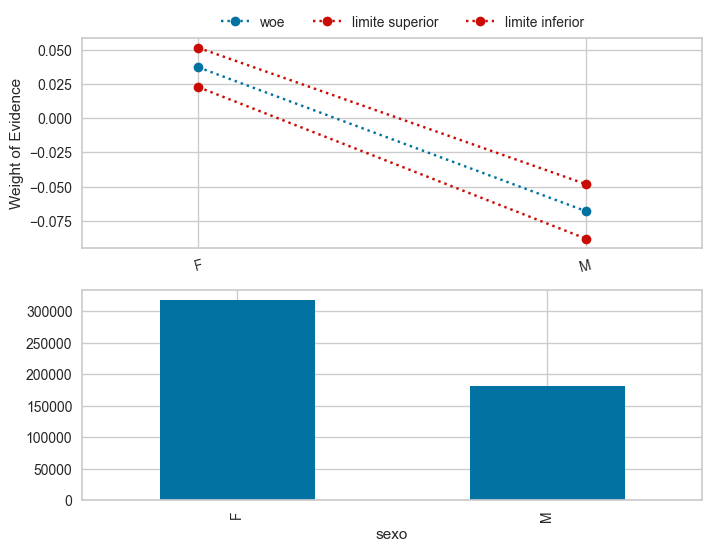

In [21]:
biv_discreta('sexo', df_)

,qt_bom,qt_mau,mau,posse_de_veiculo,cont,ep,mau_sup,mau_inf,logit,logit_sup,logit_inf,woe,woe_sup,woe_inf
posse_de_veiculo,,,,,,,,,,,,,,
N,270777,17507,0.060728,N,288284,0.000445,0.06160,0.059856,-2.738695,-2.723512,-2.754083,0.005140,0.020323,-0.010248
S,198183,12658,0.060036,S,210841,0.000517,0.06105,0.059022,-2.750901,-2.733073,-2.769014,-0.007066,0.010762,-0.025178


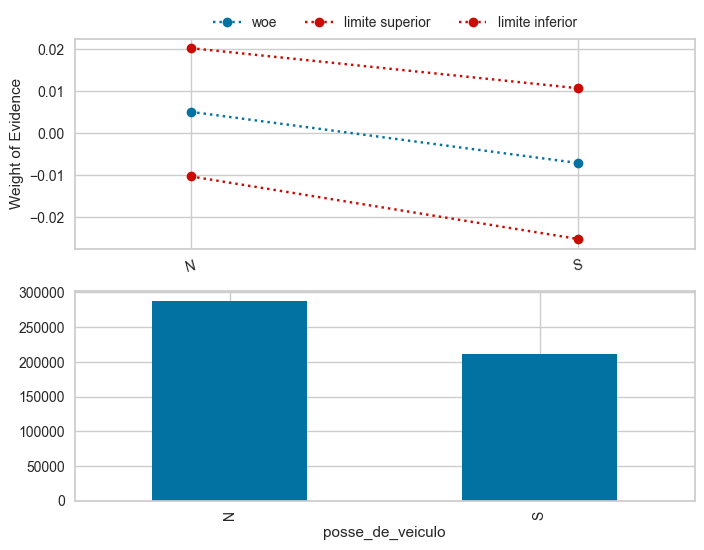

In [22]:
biv_discreta('posse_de_veiculo', df_)

,qt_bom,qt_mau,mau,posse_de_imovel,cont,ep,mau_sup,mau_inf,logit,logit_sup,logit_inf,woe,woe_sup,woe_inf
posse_de_imovel,,,,,,,,,,,,,,
N,162233,11984,0.068788,N,174217,0.000606,0.069976,0.067599,-2.605461,-2.587054,-2.624165,0.138374,0.156781,0.119670
S,306727,18181,0.055957,S,324908,0.000403,0.056748,0.055167,-2.825581,-2.810719,-2.840642,-0.081746,-0.066884,-0.096807


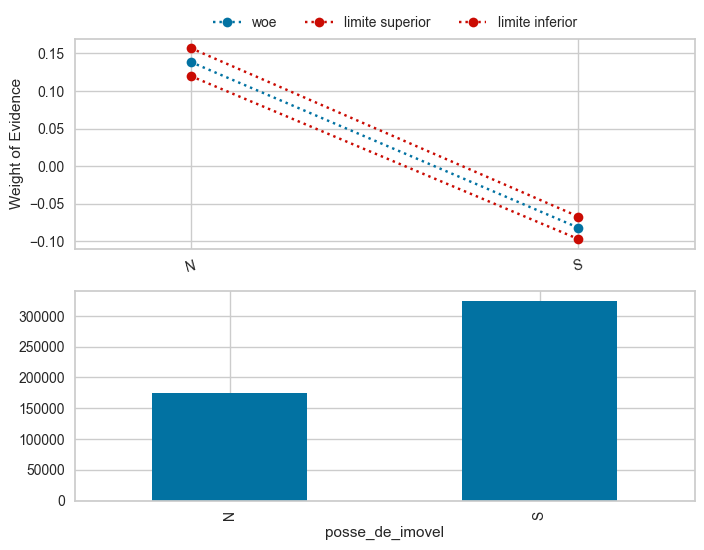

In [23]:
biv_discreta('posse_de_imovel', df_)

,qt_bom,qt_mau,mau,tipo_renda,cont,ep,mau_sup,mau_inf,logit,logit_sup,logit_inf,woe,woe_sup,woe_inf
tipo_renda,,,,,,,,,,,,,,
Assalariado,288865,19595,0.063525,Assalariado,308460,0.000439,0.064386,0.062665,-2.690685,-2.676307,-2.705246,0.053150,0.067528,0.038589
Bolsista,279,12,0.041237,Bolsista,291,0.011656,0.064178,0.018296,-3.146305,-2.679758,-3.982616,-0.402470,0.064077,-1.238781
Empresário,129935,8206,0.059403,Empresário,138141,0.000636,0.060650,0.058157,-2.762169,-2.740076,-2.784700,-0.018334,0.003759,-0.040865
Pensionista,230,22,0.087302,Pensionista,252,0.017782,0.122322,0.052281,-2.347037,-1.970623,-2.897422,0.396798,0.773213,-0.153587
Servidor público,49651,2330,0.044824,Servidor público,51981,0.000908,0.046603,0.043045,-3.059150,-3.018369,-3.101504,-0.315315,-0.274534,-0.357669


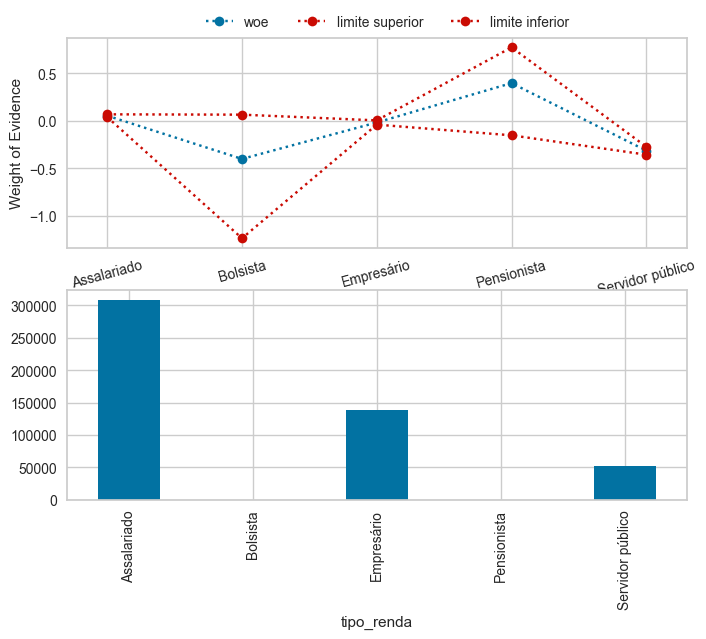

In [24]:
biv_discreta('tipo_renda', df_)

,qt_bom,qt_mau,mau,educacao,cont,ep,mau_sup,mau_inf,logit,logit_sup,logit_inf,woe,woe_sup,woe_inf
educacao,,,,,,,,,,,,,,
Fundamental,3665,278,0.070505,Fundamental,3943,0.004077,0.078498,0.062512,-2.578963,-2.462938,-2.707848,0.164873,0.280897,0.035987
Médio,305159,20261,0.062261,Médio,325420,0.000424,0.063091,0.061431,-2.712135,-2.698004,-2.726444,0.031700,0.045832,0.017391
Pós graduação,608,43,0.066052,Pós graduação,651,0.009735,0.085167,0.046937,-2.648975,-2.374126,-3.010867,0.094860,0.369709,-0.267032
Superior completo,138498,8103,0.055272,Superior completo,146601,0.000597,0.056442,0.054103,-2.838622,-2.816440,-2.861249,-0.094786,-0.072605,-0.117414
Superior incompleto,21030,1480,0.065749,Superior incompleto,22510,0.001652,0.068986,0.062511,-2.653908,-2.602364,-2.707868,0.089927,0.141471,0.035967


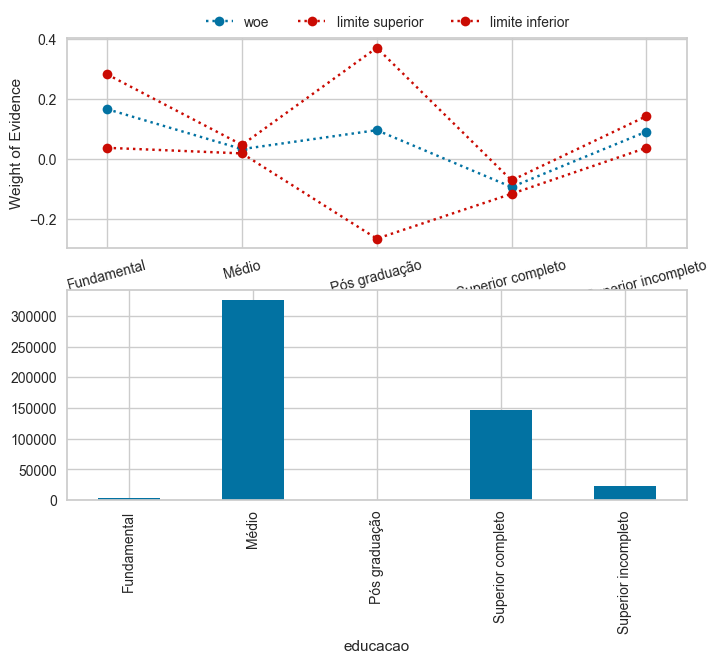

In [25]:
biv_discreta('educacao', df_)

,qt_bom,qt_mau,mau,estado_civil,cont,ep,mau_sup,mau_inf,logit,logit_sup,logit_inf,woe,woe_sup,woe_inf
estado_civil,,,,,,,,,,,,,,
Casado,334833,21177,0.059484,Casado,356010,0.000396,0.060261,0.058707,-2.760716,-2.746913,-2.774690,-0.016881,-0.003077,-0.030855
Separado,27293,1813,0.062290,Separado,29106,0.001417,0.065066,0.059513,-2.711647,-2.665071,-2.760204,0.032188,0.078764,-0.016369
Solteiro,58354,3968,0.063669,Solteiro,62322,0.000978,0.065586,0.061752,-2.688266,-2.656552,-2.720882,0.055569,0.087283,0.022953
União,37294,2630,0.065875,União,39924,0.001241,0.068309,0.063442,-2.651849,-2.612967,-2.692089,0.091987,0.130868,0.051746
Viúvo,11186,577,0.049052,Viúvo,11763,0.001991,0.052955,0.045149,-2.964576,-2.883894,-3.051593,-0.220741,-0.140059,-0.307758


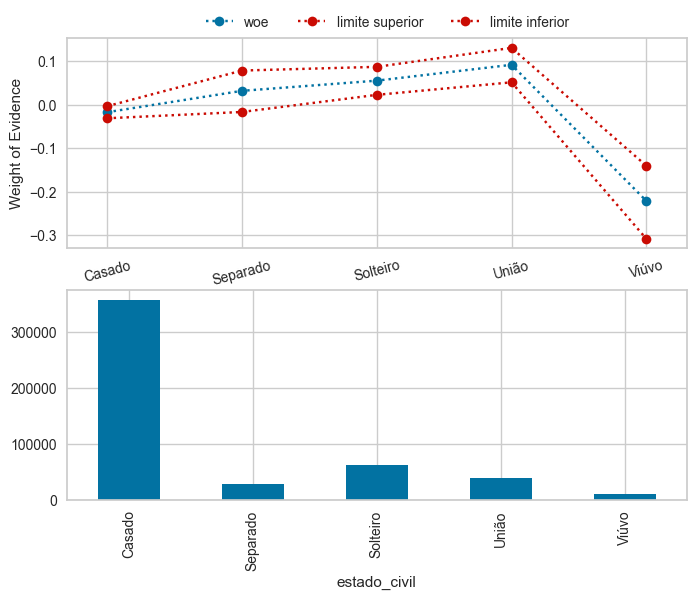

In [26]:
biv_discreta('estado_civil', df_)

,qt_bom,qt_mau,mau,tipo_residencia,cont,ep,mau_sup,mau_inf,logit,logit_sup,logit_inf,woe,woe_sup,woe_inf
tipo_residencia,,,,,,,,,,,,,,
Aluguel,7183,569,0.073400,Aluguel,7752,0.002962,0.079207,0.067594,-2.535592,-2.453174,-2.624248,0.208243,0.290662,0.119587
Casa,416221,26231,0.059286,Casa,442452,0.000355,0.059981,0.058590,-2.764274,-2.751865,-2.776821,-0.020439,-0.008030,-0.032986
Com os pais,24658,1996,0.074886,Com os pais,26654,0.001612,0.078046,0.071726,-2.513956,-2.469203,-2.560480,0.229879,0.274632,0.183355
Comunitário,2449,185,0.070235,Comunitário,2634,0.004979,0.079999,0.060472,-2.583079,-2.442363,-2.743199,0.160756,0.301473,0.000636
Estúdio,3590,200,0.052770,Estúdio,3790,0.003632,0.059891,0.045650,-2.887590,-2.753476,-3.040020,-0.143755,-0.009641,-0.296185
Governamental,14859,984,0.062109,Governamental,15843,0.001918,0.065868,0.058351,-2.714735,-2.651965,-2.781157,0.029100,0.091870,-0.037322


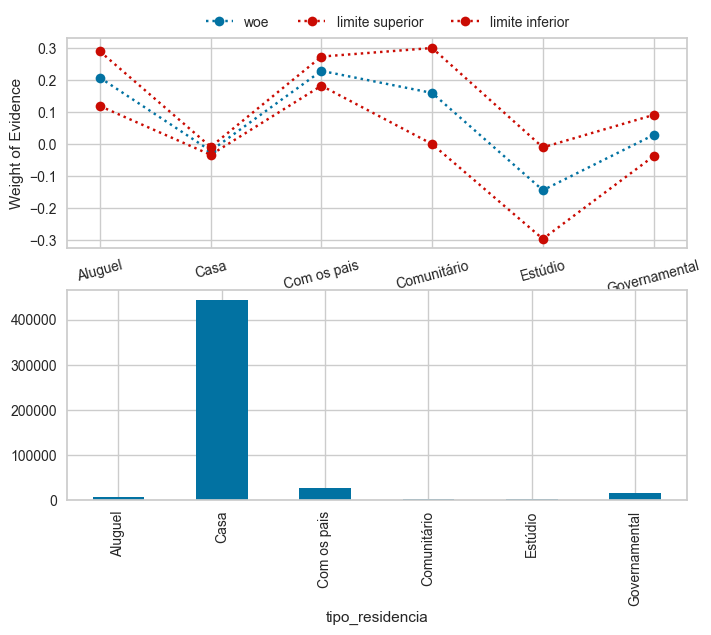

In [27]:
biv_discreta('tipo_residencia', df_)

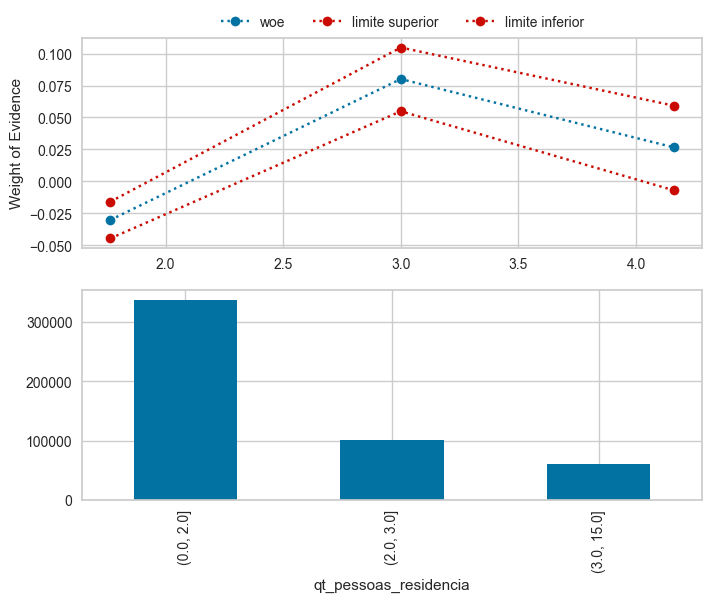

In [28]:
biv_continua('qt_pessoas_residencia',4, df_)

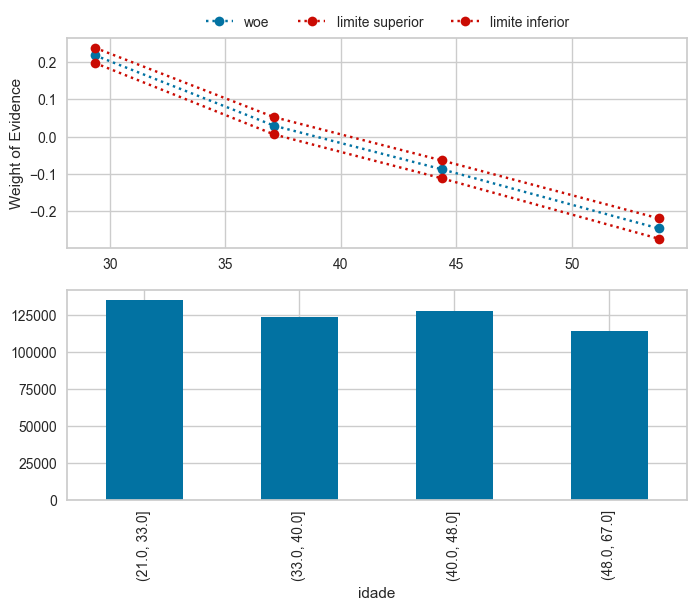

In [29]:
biv_continua('idade',4, df_)

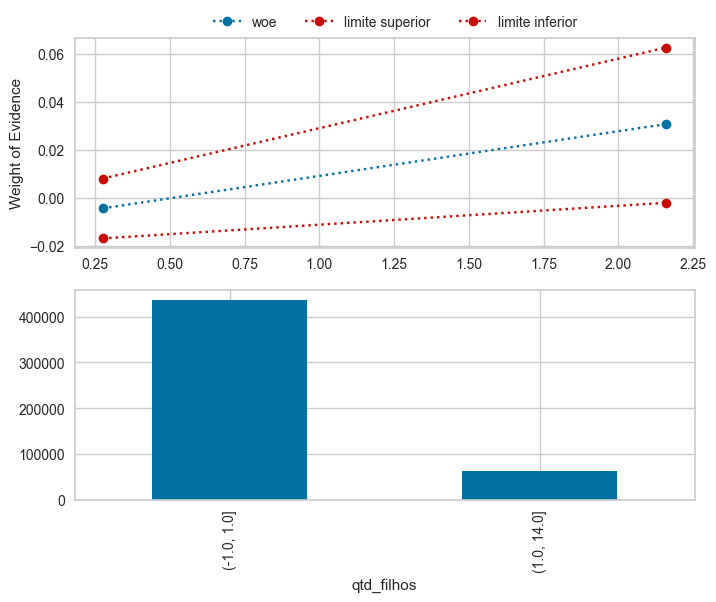

In [30]:
biv_continua('qtd_filhos',4, df_)

In [31]:
metadados.sort_values(by='IV', ascending=False)

,dtype,nmissing,valores_unicos,papel,IV
renda,float64,0,112472,covariavel,0.959826
tempo_emprego,float64,100875,3004,covariavel,0.360581
data_ref,datetime64[ns],0,12,covariavel,0.247065
idade,int64,0,47,covariavel,0.018434
tipo_renda,object,0,5,covariavel,0.009718
posse_de_imovel,object,0,2,covariavel,0.009690
educacao,object,0,5,covariavel,0.003690
tipo_residencia,object,0,6,covariavel,0.003330
index,int64,0,16650,covariavel,0.002716
sexo,object,0,2,covariavel,0.002665


In [32]:
' + '.join(list(metadados.sort_values(by='IV', ascending=False).index))

'renda + tempo_emprego + data_ref + idade + tipo_renda + posse_de_imovel + educacao + tipo_residencia + index + sexo + estado_civil + qt_pessoas_residencia + posse_de_veiculo + qtd_filhos + mau'

In [33]:
formula = 'mau~renda + tempo_emprego + idade + tipo_renda + posse_de_imovel'

In [34]:
rl = smf.glm(formula, data=df_, family=sm.families.Binomial()).fit()

rl.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                    mau   No. Observations:               499125
Model:                            GLM   Df Residuals:                   499116
Model Family:                Binomial   Df Model:                            8
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -1.0255e+05
Date:                Wed, 25 Oct 2023   Deviance:                   2.0498e+05
Time:                        12:59:50   Pearson chi2:                 1.45e+16
No. Iterations:                    11   Pseudo R-squ. (CS):            0.04441
Covariance Type:            nonrobust                                         
==================================================================================================
                                     coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
Intercept                         -1.5698      0.028    -56.138      0.000      -1.625      -1.515
tipo_renda[T.Bolsista]             0.0994      0.300      0.332      0.740      -0.488       0.687
tipo_renda[T.Empresário]          -0.0529      0.014     -3.819      0.000      -0.080      -0.026
tipo_renda[T.Pensionista]          0.0123      0.226      0.055      0.956      -0.431       0.455
tipo_renda[T.Servidor público]    -0.0400      0.023     -1.736      0.083      -0.085       0.005
posse_de_imovel[T.S]              -0.0958      0.013     -7.666      0.000      -0.120      -0.071
renda                          -9.889e-05   1.17e-06    -84.227      0.000      -0.000   -9.66e-05
tempo_emprego                     -0.0252      0.002    -13.937      0.000      -0.029      -0.022
idade                              0.0009      0.001      1.294      0.196      -0.000       0.002
==================================================================================================
"""

## Avaliação do modelo

Avalie o poder discriminante do modelo pelo menos avaliando acurácia, KS e Gini.

Avalie estas métricas nas bases de desenvolvimento e *out of time*.

In [35]:
df_['score'] = rl.predict(df_)

# Acurácia
acc = metrics.accuracy_score(df_.mau, df_.score>.090)
#AUC
fpr, tpr, thresholds = metrics.roc_curve(df_.mau, df_.score)
auc = metrics.auc(fpr, tpr)
#Gini
gini = 2*auc -1
ks = ks_2samp(df_.loc[df_.mau == 1, 'score'], df_.loc[df_.mau != 1, 'score']).statistic

print('Acurácia: {0:.1%} \nAUC: {1:.1%} \nGINI: {2:.1%}\nKS: {3:.1%}'
      .format(acc, auc, gini, ks))

Acurácia: 71.5% 
AUC: 77.4% 
GINI: 54.9%
KS: 40.7%


In [36]:
df_valid = df_valid.dropna()

In [37]:
df_valid['score'] = rl.predict(df_valid)

# Acurácia
acc = metrics.accuracy_score(df_valid.mau, df_valid.score>.090)
#AUC
fpr, tpr, thresholds = metrics.roc_curve(df_valid.mau, df_valid.score)
auc = metrics.auc(fpr, tpr)
#Gini
gini = 2*auc -1
ks = ks_2samp(df_valid.loc[df_valid.mau == 1, 'score'], df_valid.loc[df_valid.mau != 1, 'score']).statistic

print('Acurácia: {0:.1%} \nAUC: {1:.1%} \nGINI: {2:.1%}\nKS: {3:.1%}'
      .format(acc, auc, gini, ks))

Acurácia: 44.5% 
AUC: 73.5% 
GINI: 47.1%
KS: 34.7%


## Criar um pipeline utilizando o sklearn pipeline 

In [38]:
from sklearn.pipeline import Pipeline

## Pré processamento

### Substituição de nulos (nans)

Existe nulos na base? é dado numérico ou categórico? qual o valor de substituição? média? valor mais frequente? etc

In [42]:
from sklearn.pipeline import Pipeline

### Remoção de outliers

Como identificar outlier? Substituir o outlier por algum valor? Remover a linha?

In [43]:
from sklearn.impute import SimpleImputer

In [44]:
nulo_pipe = SimpleImputer(strategy='constant', fill_value=np.nan)

### Redução de dimensionalidade (PCA)

Aplicar PCA para reduzir a dimensionalidade para 5

In [45]:
# Define a PCA to Linear dimensionality reduction
pca_pipe = PCA(n_components=5)

### Pipeline 

Crie um pipeline contendo essas funções.

preprocessamento()
- substituicao de nulos
- remoção outliers
- PCA
- Criação de dummy de pelo menos 1 variável (posse_de_veiculo)

In [46]:
pipe = Pipeline(steps=[("nulo", nulo_pipe), 
                       ("pca", pca_pipe)])

### Salvar o pickle file do modelo treinado

In [48]:
import pickle

nome_arquivo = 'model_final.pkl'
pickle.dump(rl, open(nome_arquivo, 'wb'))

# Pycaret na base de dados 

Utilize o pycaret para pre processar os dados e rodar o modelo **lightgbm**. Faça todos os passos a passos da aula e gere os gráficos finais. E o pipeline de toda a transformação.



In [49]:
import pandas as pd

df = pd.read_feather('credit_scoring.ftr')
df.head()

,data_ref,index,sexo,posse_de_veiculo,posse_de_imovel,qtd_filhos,tipo_renda,educacao,estado_civil,tipo_residencia,idade,tempo_emprego,qt_pessoas_residencia,renda,mau
0,2015-01-01,5733,F,N,N,0,Empresário,Médio,Solteiro,Casa,43,6.873973,1.0,2515.39,False
1,2015-01-01,727,F,S,S,0,Assalariado,Médio,Casado,Casa,35,4.526027,2.0,3180.19,False
2,2015-01-01,6374,F,N,N,2,Assalariado,Médio,Casado,Casa,31,0.243836,4.0,1582.29,False
3,2015-01-01,9566,F,N,N,0,Assalariado,Médio,Casado,Casa,54,12.772603,2.0,13721.17,False
4,2015-01-01,9502,F,S,N,0,Assalariado,Superior incompleto,Solteiro,Casa,31,8.432877,1.0,2891.08,False


In [55]:
setup(df,target='mau',session_id=7,normalize=True, feature_selection = True, remove_multicollinearity = True,fix_imbalance=True,remove_outliers=True,preprocess= pipe)

,Description,Value
0,Session id,7
1,Target,mau
2,Target type,Binary
3,Original data shape,"(750000, 15)"
4,Transformed data shape,"(1144866, 3)"
5,Transformed train set shape,"(919866, 3)"
6,Transformed test set shape,"(225000, 3)"
7,Ordinal features,3
8,Numeric features,6
9,Date features,1


In [56]:
from pycaret.classification import *
models()

,Name,Reference,Turbo
ID,,,
lr,Logistic Regression,sklearn.linear_model._logistic.LogisticRegression,True
knn,K Neighbors Classifier,sklearn.neighbors._classification.KNeighborsCl...,True
nb,Naive Bayes,sklearn.naive_bayes.GaussianNB,True
dt,Decision Tree Classifier,sklearn.tree._classes.DecisionTreeClassifier,True
svm,SVM - Linear Kernel,sklearn.linear_model._stochastic_gradient.SGDC...,True
rbfsvm,SVM - Radial Kernel,sklearn.svm._classes.SVC,False
gpc,Gaussian Process Classifier,sklearn.gaussian_process._gpc.GaussianProcessC...,False
mlp,MLP Classifier,sklearn.neural_network._multilayer_perceptron....,False
ridge,Ridge Classifier,sklearn.linear_model._ridge.RidgeClassifier,True


In [57]:
lightgbm = create_model('lightgbm')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.8851,0.7752,0.3181,0.2879,0.3022,0.2398,0.2402
1,0.7137,0.7601,0.6658,0.1667,0.2667,0.1618,0.2222
2,0.8895,0.7772,0.2928,0.2933,0.2931,0.2332,0.2332
3,0.7109,0.7621,0.6826,0.1680,0.2697,0.1649,0.2283
4,0.8829,0.7759,0.3279,0.2843,0.3046,0.2410,0.2417
5,0.7100,0.7613,0.6838,0.1678,0.2694,0.1645,0.2282
6,0.7110,0.7540,0.6646,0.1651,0.2645,0.1592,0.2194
7,0.7117,0.7540,0.6631,0.1652,0.2645,0.1592,0.2192
8,0.8864,0.7790,0.3130,0.2901,0.3011,0.2394,0.2396


In [58]:
predict = predict_model(lightgbm, data=df_)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Light Gradient Boosting Machine,0.7761,0.7488,0.5527,0.1450,0.2298,0.1482,0.1942


In [59]:
evaluate_model(lightgbm)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

### Salvar o arquivo do modelo treinado

In [60]:
save_model(lightgbm,'lightgbm_final')

Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=Memory(location=None),
          steps=[('date_feature_extractor',
                  TransformerWrapper(exclude=None, include=['data_ref'],
                                     transformer=ExtractDateTimeFeatures(features=['day',
                                                                                   'month',
                                                                                   'year']))),
                 ('numerical_imputer',
                  TransformerWrapper(exclude=None,
                                     include=['index', 'qtd_filhos', 'idade',
                                              'tempo_emprego',
                                              'qt_pessoas_residencia', 'renda'],
                                     transformer=Sim...
                  LGBMClassifier(boosting_type='gbdt', class_weight=None,
                                 colsample_bytree=1.0, importance_type='split',
                                 learning_ra

# Projeto Final

1. Subir no GITHUB todos os jupyter notebooks/códigos que você desenvolveu nesse ultimo módulo
1. Gerar um arquivo python (.py) com todas as funções necessárias para rodar no streamlit a escoragem do arquivo de treino
    - Criar um .py
    - Criar um carregador de csv no streamlit 
    - Subir um csv no streamlit 
    - Criar um pipeline de pré processamento dos dados
    - Utilizar o modelo treinado para escorar a base 
        - nome_arquivo = 'model_final.pkl'
1. Gravar um vídeo da tela do streamlit em funcionamento (usando o próprio streamlit (temos aula disso) ou qlqr outra forma de gravação).
1. Subir no Github o vídeo de funcionamento da ferramenta como README.md.
1. Subir no Github os códigos desenvolvidos. 
1. Enviar links do github para o tutor corrigir.